<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/ML%20TMS%20feature%20Shapley%20vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Install necessary packages (if not already installed in the environment) ---
# We'll use H2O for AutoML
!pip install h2o --quiet

# --- Import necessary libraries ---
import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
import warnings
warnings.filterwarnings("ignore") # Suppress potential warnings

# --- 1. Initialize H2O ---
print("Initializing H2O...")
h2o.init()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 5.2 MB/s eta 0:00:00
Initializing H2O...
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp_12twm55
  JVM stdout: /tmp/tmp_12twm55/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp_12twm55/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,"14 days, 2 hours and 19 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_rwao0u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.168 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [2]:
link_url = 'https://raw.githubusercontent.com/TAUforPython/BioMedAI/refs/heads/main/test_datasets/tms_timeseries_clusters.csv'

raw_data = pd.read_csv(link_url, sep = ',')
raw_data = raw_data.drop('Unnamed: 0',axis=1)
raw_data.head(5)

,patient_id,Avg_Resp_Left_Mean,Avg_Resp_Left_Std,Avg_Resp_Left_Hurst,Avg_Resp_Right_Mean,Avg_Resp_Right_Std,Avg_Resp_Right_Hurst,Avg_Resp_DTW_Cluster,Inh_Thresh_DTW_Cluster
0,patient_ 1n,53.259528,12.009135,0.397920,194.736574,40.132561,1.917325,0.0,3
1,patient_ 2n,123.597025,41.771269,1.163941,109.284255,41.218117,1.462129,1.0,1
2,patient_ 3n,39.701583,21.652062,1.099086,84.205208,32.102390,1.186651,3.0,1
3,patient_ 4n,73.540167,23.046395,0.802684,64.819444,13.978575,1.351294,1.0,1
4,patient_ 5n,100.746296,14.629567,0.809085,38.125000,10.383945,0.789748,1.0,1


In [3]:
df = raw_data

In [7]:
# --- 3. Data Preprocessing for H2O ---
# Identify columns to use for modeling (features and potential targets)
# Exclude 'patient_id' as it's an identifier
all_columns = df.columns.tolist()
feature_columns = [col for col in all_columns if col != 'patient_id']

print(f"\nAll columns: {all_columns}")
print(f"\nFeature columns identified: {feature_columns}")

# Handle missing values (H2O can handle some NA, but for consistency in target evaluation,
# let's drop rows with any missing values in potential target columns)
# It's often better to let H2O handle missing values internally for features during modeling.
# However, for evaluating target performance, clean targets are needed.
# Let's drop rows where ANY column has missing values for this analysis.
df_clean = df.dropna()
print(f"\nShape after dropping rows with missing values: {df_clean.shape}")

X_clean_df = df_clean[feature_columns].copy()
y_potential_df = df_clean[feature_columns] # All features are potential targets

# Convert the clean pandas DataFrame to an H2O Frame
h2o_df = h2o.H2OFrame(df_clean)
print("\nData successfully converted to H2O Frame.")


All columns: ['patient_id', 'Avg_Resp_Left_Mean', 'Avg_Resp_Left_Std', 'Avg_Resp_Left_Hurst', 'Avg_Resp_Right_Mean', 'Avg_Resp_Right_Std', 'Avg_Resp_Right_Hurst', 'Avg_Resp_DTW_Cluster', 'Inh_Thresh_DTW_Cluster']

Feature columns identified: ['Avg_Resp_Left_Mean', 'Avg_Resp_Left_Std', 'Avg_Resp_Left_Hurst', 'Avg_Resp_Right_Mean', 'Avg_Resp_Right_Std', 'Avg_Resp_Right_Hurst', 'Avg_Resp_DTW_Cluster', 'Inh_Thresh_DTW_Cluster']

Shape after dropping rows with missing values: (60, 9)
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%

Data successfully converted to H2O Frame.


In [8]:
# --- 4. Define a function to evaluate H2O AutoML performance for each potential target column ---
def find_best_target_h2o_automl(h2o_frame, feature_cols, potential_target_cols, max_runtime_secs=120):
    """
    Iterates through each column in potential_target_cols, treating it as a target,
    and uses H2O AutoML to build a model. The performance (e.g., R2 for regression,
    AUC/M logloss for classification) of the model is used as a proxy to determine
    the 'best' target column. Higher performance might indicate that the column
    is easier to predict from the other features, suggesting a strong underlying
    relationship or structure.
    """
    results = {}
    best_score = float('-inf') # We'll use a generic 'score', taking the primary metric
    best_column = None
    best_task = None
    best_leaderboard = None

    for col in potential_target_cols:
        print(f"\n--- Evaluating '{col}' as potential target ---")
        y = col
        X = [c for c in feature_cols if c != y] # Use all other features as predictors

        # Determine task type based on the target column's data type in the H2O frame
        h2o_type = h2o_frame.type(col)
        print(f"  H2O determined type for '{col}': {h2o_type}")

        # H2O usually infers 'enum' for categorical/string and 'int'/'real' for numeric.
        # For integer columns that might represent clusters (classification),
        # H2O might still treat them as regression. We might need to explicitly convert.
        # Let's assume H2O's inference is mostly correct for now, but check unique values.
        unique_vals_frame = h2o_frame[y].unique()
        unique_count = unique_vals_frame.nrows
        total_count = h2o_frame.nrows
        print(f"  Unique values in '{col}': {unique_count}")

        if h2o_type == 'enum' or unique_count < max(2, total_count * 0.05): # Treat as classification
             task = 'classification'
             # Ensure the target is treated as enum if it's numeric but categorical
             h2o_frame[y] = h2o_frame[y].asfactor()
        elif h2o_type in ['int', 'real']:
             task = 'regression'
        else:
            print(f"  Skipping '{col}' due to unsupported H2O type: {h2o_type}")
            continue

        print(f"  Determined task type: {task}")

        # Split the H2O frame
        train, test = h2o_frame.split_frame(ratios=[0.8], seed=42)

        # Initialize H2O AutoML
        aml = H2OAutoML(
            max_runtime_secs=max_runtime_secs, # Run for max 2 minutes per target
            seed=42,
            verbosity='info' # Can be 'info', 'warn', 'quiet' to manage output
        )

        # Fit the AutoML model
        print(f"  Fitting H2O AutoML for {task} on '{col}'...")
        aml.train(x=X, y=y, training_frame=train)

        # Check the leaderboard for the best model's performance
        lb = aml.leaderboard
        print(lb.head())

        if lb.nrows == 0:
            print(f"  No models were trained successfully for target '{col}'. Skipping.")
            continue

        # Get the primary metric for the best model
        # H2O AutoML leaderboard has standard column names.
        # For regression: 'r2', 'rmse', 'mae', 'deviance'
        # For classification: 'mean_per_class_error', 'logloss', 'AUC' (if binary), 'AUCpr'
        # We'll take the best model's R2 for regression or mean_per_class_error (minimize) or logloss (minimize) for classification.
        best_model_id = lb[0, 'model_id']
        print(f"  Best model for '{col}': {best_model_id}")

        if task == 'regression':
            # Look for R2 score (higher is better)
            if 'r2' in lb.columns:
                score_val = lb[0, 'r2']
                score_name = "R2"
                if score_val is not None:
                    score_val = float(score_val) # H2O returns H2OFloat, convert to Python float
                    score = score_val # Higher R2 is better
                else:
                     print(f"    R2 not found for best model of '{col}', using 0.")
                     score = 0.0
            else:
                # If R2 is not present (e.g., if all models failed to report it), use another metric like negative RMSE
                rmse_val = lb[0, 'rmse']
                if rmse_val is not None:
                    rmse_val = float(rmse_val)
                    score = -rmse_val # Negative RMSE, so higher (less negative) is better
                    score_name = "-RMSE"
                else:
                     print(f"    R2 and RMSE not found for best model of '{col}', using 0.")
                     score = 0.0
                     score_name = "Placeholder"

        elif task == 'classification':
             # Look for mean_per_class_error (lower is better) or logloss (lower is better)
             # We want a score where HIGHER is better, so we'll use negative error or inverse of logloss if needed.
             # logloss is usually lower for better models. We can use negative logloss.
             if 'logloss' in lb.columns and lb[0, 'logloss'] is not None:
                 logloss_val = float(lb[0, 'logloss'])
                 score = -logloss_val # Negative logloss, so higher (less negative) is better
                 score_name = "-LogLoss"
             elif 'mean_per_class_error' in lb.columns and lb[0, 'mean_per_class_error'] is not None:
                  mce_val = float(lb[0, 'mean_per_class_error'])
                  score = -mce_val # Negative mean per class error, so higher (less negative) is better
                  score_name = "-MeanPerClassError"
             elif 'auc' in lb.columns and lb[0, 'auc'] is not None: # For binary classification
                  auc_val = float(lb[0, 'auc'])
                  score = auc_val # AUC, higher is better
                  score_name = "AUC"
             else:
                 print(f"    No standard classification metric found for best model of '{col}', using 0.")
                 score = 0.0
                 score_name = "Placeholder"

        print(f"  Best {score_name} for '{col}': {score:.4f}")

        results[col] = {
            'score': score,
            'score_name': score_name,
            'task': task,
            'leaderboard': lb
        }

        # Update best column if current score is better
        # Note: This comparison works if score is consistently higher for better performance
        if score > best_score:
            best_score = score
            best_column = col
            best_task = task
            best_leaderboard = lb

    print("\n--- Summary of H2O AutoML Performance for Potential Targets ---")
    # Sort results by score (descending) for better readability
    sorted_results = sorted(results.items(), key=lambda item: item[1]['score'], reverse=True)
    for col, res in sorted_results:
        print(f"  {col:<25} | {res['score_name']:<15} | {res['score']:.4f} | Task: {res['task']}")
    print(f"\nBest target column based on H2O AutoML performance: '{best_column}' with {results[best_column]['score_name']}: {best_score:.4f} (Task: {best_task})")

    return best_column, best_score, best_task, results, best_leaderboard


# --- Run the H2O AutoML-based target identification ---
best_target_col, best_score, best_task, all_results, best_lb = find_best_target_h2o_automl(
    h2o_df, feature_columns, y_potential_df.columns, max_runtime_secs=120
)

# --- Print the leaderboard for the best target ---
print(f"\n--- Leaderboard for the Best Target ('{best_target_col}') ---")
print(best_lb)

# --- 5. Shutdown H2O ---
print("\nShutting down H2O...")
h2o.shutdown(prompt=False)

print("\nDone.")


--- Evaluating 'Avg_Resp_Left_Mean' as potential target ---
  H2O determined type for 'Avg_Resp_Left_Mean': real
  Unique values in 'Avg_Resp_Left_Mean': 59
  Determined task type: regression
  Fitting H2O AutoML for regression on 'Avg_Resp_Left_Mean'...
AutoML progress: |
19:03:38.993: Project: AutoML_1_20251208_190338
19:03:38.997: 5-fold cross-validation will be used.
19:03:38.997: Setting stopping tolerance adaptively based on the training frame: 0.05
19:03:38.999: Build control seed: 42
19:03:39.0: training frame: Frame key: AutoML_1_20251208_190338_training_py_3_sid_acf3    cols: 9    rows: 50  chunks: 1    size: 3916  checksum: -4487462782626483852
19:03:39.0: validation frame: NULL
19:03:39.1: leaderboard frame: NULL
19:03:39.3: blending frame: NULL
19:03:39.3: response column: Avg_Resp_Left_Mean
19:03:39.3: fold column: null
19:03:39.3: weights column: null
19:03:39.42: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), 

# Shapley values
Initialize H2O, load `df_clean` into an H2OFrame, retrieve the best model using `best_lb`, calculate Shapley values for the best model on the training data, and then visualize the feature importance using these Shapley values.

In [9]:
!pip install shap --quiet

**Reasoning**:
Re-initialize H2O and import the shap library as requested by the subtask.



In [10]:
#import h2o
import shap

print("Re-initializing H2O...")
h2o.init()

Re-initializing H2O...
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.16" 2025-07-15; OpenJDK Runtime Environment (build 17.0.16+8-Ubuntu-0ubuntu122.04.1); OpenJDK 64-Bit Server VM (build 17.0.16+8-Ubuntu-0ubuntu122.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpbriovnik
  JVM stdout: /tmp/tmpbriovnik/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpbriovnik/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,"14 days, 2 hours and 52 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_kdjwih
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.168 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [11]:
# Re-create H2OFrame for the current session
h2o_df_current_session = h2o.H2OFrame(df_clean)

# Get the best target column and task from the previous analysis
y_col = best_target_col
x_cols = [col for col in feature_columns if col != y_col]
task = best_task

# Ensure the target column is correctly typed for the task in the current H2OFrame
if task == 'classification':
    h2o_df_current_session[y_col] = h2o_df_current_session[y_col].asfactor()

print(f"Re-running AutoML for target '{y_col}' (Task: {task}) to obtain a valid model in the current H2O session...")

# Re-run AutoML for the best target column in the current session
aml_current_session = H2OAutoML(
    max_runtime_secs=60, # Reduced runtime to quickly get a model for SHAP
    seed=42,
    verbosity='warn'
)
aml_current_session.train(x=x_cols, y=y_col, training_frame=h2o_df_current_session)

# Get the new best model from the current session's AutoML leaderboard
current_best_lb = aml_current_session.leaderboard
model_id = current_best_lb[0, 'model_id']
best_model = h2o.get_model(model_id)

# Convert feature data to H2OFrame for SHAP, excluding the target column
h2o_feature_frame = h2o.H2OFrame(df_clean[[col for col in feature_columns if col != y_col]])

print(f"Loaded best model from current session: {best_model.model_id}")
print("Feature data converted to H2OFrame.")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Re-running AutoML for target 'Avg_Resp_Left_Hurst' (Task: regression) to obtain a valid model in the current H2O session...
AutoML progress: |█████
19:23:02.794: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 60.0.

██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Loaded best model from current session: GBM_grid_1_AutoML_1_20251208_192256_model_9
Feature data converted to H2OFrame.


**Reasoning**:
Now that the H2O model and feature data are ready, I will calculate SHAP values using `shap.TreeExplainer` for the first two data points from the `h2o_feature_frame`. This will provide the necessary values to create individual force plots as requested by the subtask.



In [12]:
contributions = best_model.predict_contributions(h2o_feature_frame)

# Convert the H2OFrame contributions to a pandas DataFrame
contributions_df = contributions.as_data_frame()

# Extract SHAP values (all columns except 'BiasTerm')
shap_values_individual = contributions_df.drop(columns=['BiasTerm']).values

# The 'BiasTerm' represents the expected value (base value)
# We take the first value as expected_value is typically constant for a given model or dataset
expected_value = contributions_df['BiasTerm'].iloc[0]

print(f"SHAP values calculated using H2O's predict_contributions.")
print(f"Calculated SHAP values for {len(shap_values_individual)} instances.")
print(f"Expected (base) value: {expected_value}")

contributions progress: |████████████████████████████████████████████████████████| (done) 100%
SHAP values calculated using H2O's predict_contributions.
Calculated SHAP values for 60 instances.
Expected (base) value: 1.319496989250183


Generating SHAP force plot for instance 1...


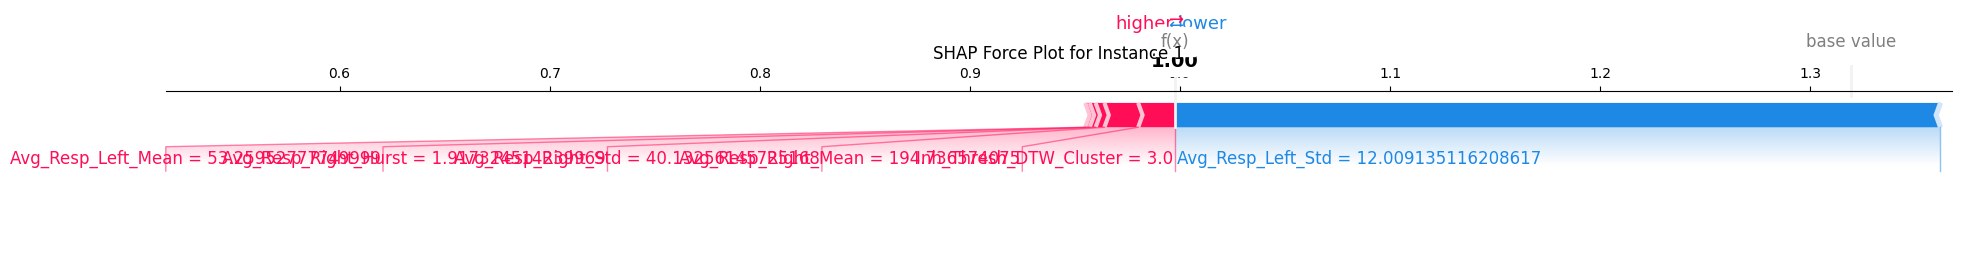

Generating SHAP force plot for instance 2...


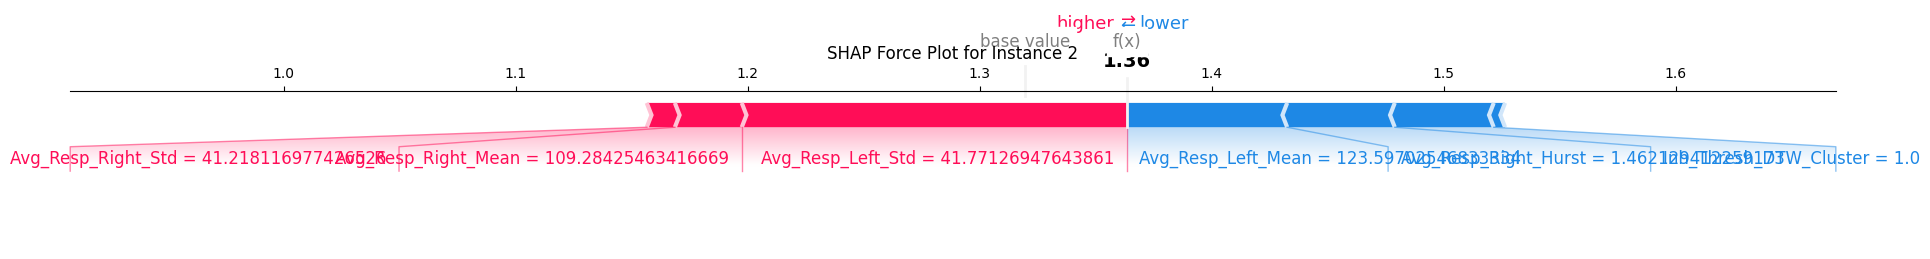

In [13]:
import matplotlib.pyplot as plt

# Get the feature names directly from the h2o_feature_frame for consistent labeling
feature_names = h2o_feature_frame.col_names

# Select the first two instances for plotting
instance_1_shap_values = shap_values_individual[0]
instance_1_features = df_clean[[col for col in feature_columns if col != y_col]].iloc[0]

instance_2_shap_values = shap_values_individual[1]
instance_2_features = df_clean[[col for col in feature_columns if col != y_col]].iloc[1]

print("Generating SHAP force plot for instance 1...")
shap.force_plot(expected_value, instance_1_shap_values, instance_1_features, matplotlib=True, show=False)
plt.title("SHAP Force Plot for Instance 1")
plt.tight_layout()
plt.show()

print("Generating SHAP force plot for instance 2...")
shap.force_plot(expected_value, instance_2_shap_values, instance_2_features, matplotlib=True, show=False)
plt.title("SHAP Force Plot for Instance 2")
plt.tight_layout()
plt.show()

# LightAutoML

In [14]:

!pip install -U lightautoml -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.5/412.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 6.1 MB/s eta 0:00:00


In [15]:
# Импорт библиотек для auto ml

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco, ReportDecoUtilized
from lightautoml.addons.tabular_interpretation import SSWARM

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch

In [16]:
N_THREADS = 4 #number of vCPUs for LightAutoML model creation
N_FOLDS = 2 # number of folds in LightAutoML inner CV
#All models that are trained during the cross-validation loop
#on different folds are then saved for the inference phase.
#Inference on new data is made by averaging models from all train folds.

RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 100 # Time in seconds for automl run
TARGET_NAME = 'Avg_Resp_DTW_Cluster' # Target column name

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

autoML_df = df


In [19]:
autoML_df = autoML_df.dropna()

In [21]:

train_data, test_data = train_test_split(
    autoML_df,
    test_size=TEST_SIZE,
    stratify=autoML_df[TARGET_NAME],
    random_state=RANDOM_STATE
)

print(f'Data is splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

train_data.head()

Data is splitted. Parts sizes: train_data = (48, 9), test_data = (12, 9)


,patient_id,Avg_Resp_Left_Mean,Avg_Resp_Left_Std,Avg_Resp_Left_Hurst,Avg_Resp_Right_Mean,Avg_Resp_Right_Std,Avg_Resp_Right_Hurst,Avg_Resp_DTW_Cluster,Inh_Thresh_DTW_Cluster
2,patient_ 3n,39.701583,21.652062,1.099086,84.205208,32.102390,1.186651,3.0,1
58,patient_ 45,86.609226,24.699766,0.965192,61.637611,23.023425,1.693853,1.0,0
26,patient_ 10,41.774348,17.719056,1.590113,182.984583,86.465844,1.227551,0.0,3
48,patient_ 35,149.761161,53.176081,2.036485,121.672768,21.297929,0.734508,2.0,2
19,patient_ 3,189.062500,63.825718,1.729370,145.275000,35.421334,0.495146,2.0,2


In [22]:
#The following task types are available:
#'binary' - for binary classification.
#'reg’ - for regression.
#‘multiclass’ - for multiclass classification.
#'multi:reg - for multiple regression.
#'multilabel' - for multi-label classification.

task = Task('multiclass')


roles = {
    'target': TARGET_NAME
    #'category': TARGET_NAME
    #'drop': ['name of column']
}

In [23]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [24]:
out_of_fold_predictions = automl.fit_predict(train_data, roles = roles, verbose = 2)


[19:53:39] Stdout logging level is INFO2.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO2.


[19:53:39] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


[19:53:39] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[19:53:39] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[19:53:39] - time: 100.00 seconds


INFO:lightautoml.automl.presets.base:- time: 100.00 seconds


[19:53:39] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[19:53:39] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[19:53:39] Train data shape: (48, 9)



INFO:lightautoml.reader.base:Train data shape: (48, 9)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[19:53:54] Layer 1 train process start. Time left 84.43 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 84.43 secs


[19:53:54] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2], 'embed_sizes': array([1, 5, 1], dtype=int32), 'data_size': 12}


[19:53:54] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.216386342152197
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1.2151706406040415
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -1.2136532466746148
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -1.2015390253059752
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -1.1873415760582986
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = -1.0929720351317622
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = -1.009604516196271
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = -0.7735850532992331
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 scor

[19:53:57] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.281879822181631
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1.2806537915202203
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -1.279133882319098
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -1.2670631498702747
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -1.252333309948085
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = -1.1533149987633673
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = -1.0617204128207316
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = -0.7738466901629651
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score

[19:53:58] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5246206168713178


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5246206168713178


[19:53:58] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:53:58] Time left 80.95 secs



INFO:lightautoml.automl.base:Time left 80.95 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696


[19:53:58] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[19:53:58] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[19:53:58] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696


[19:53:58] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.2819
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.2819
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.2819


[19:53:58] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.2494258998977519


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.2494258998977519


[19:53:58] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:53:58] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 15.26 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 15.26 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-fc8a3b7f-d71f-4653-8429-2db7ee880907
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696
INFO:optuna.study.study:Trial 0 finished with value: -1.2169560388091087 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is tri

[19:54:10] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed


[19:54:10] The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -1.2170 crossentropy


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -1.2170 crossentropy


[19:54:10] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.24810409748678125}


[19:54:10] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696


[19:54:10] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.2819
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.2819


[19:54:10] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1.2494258998977519


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1.2494258998977519


[19:54:10] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[19:54:10] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[19:54:10] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3603254	test: 1.3739325	best: 1.3739325 (0)	total: 46.6ms	remaining: 2m 19s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.4014715	test: 1.7885403	best: 1.3295047 (8)	total: 84.3ms	remaining: 2.42s
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.329504737
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 8
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 9 iterations.


[19:54:10] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3594515	test: 1.3819390	best: 1.3819390 (0)	total: 1.88ms	remaining: 5.64s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.3298581	test: 1.9710756	best: 1.3369315 (12)	total: 27.7ms	remaining: 794ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.336931505
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 12
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 13 iterations.


[19:54:10] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.333218111715515


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.333218111715515


[19:54:10] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[19:54:10] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 41.34 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 41.34 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-0c028919-b9c6-4dea-9146-b797b1c3a887
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3792060	test: 1.3809213	best: 1.3809213 (0)	total: 588us	remaining: 1.76s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.9487910	test: 1.3056426	best: 1.2882056 (59)	total: 15ms	remaining: 431ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.288205646
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 59
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 60 iterations.
INFO:optuna.study.study:Trial 0 finished with value: -1.2882056414832868 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf':

[19:54:22] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed


[19:54:22] The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 7.207429548070938, 'min_data_in_leaf': 13}
 achieve -1.2780 crossentropy


INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 7.207429548070938, 'min_data_in_leaf': 13}
 achieve -1.2780 crossentropy


[19:54:22] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 7.207429548070938, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 13, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}


[19:54:22] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3821655	test: 1.3826818	best: 1.3826818 (0)	total: 208us	remaining: 626ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 1.0790061	test: 1.2782943	best: 1.2782076 (99)	total: 25.4ms	remaining: 729ms
INFO3:lightautoml.ml_algo.boost_cb:200:	learn: 0.9145793	test: 1.3283453	best: 1.2780466 (105)	total: 45.6ms	remaining: 636ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.278046555
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 105
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 106 iterations.


[19:54:22] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3825577	test: 1.3839808	best: 1.3839808 (0)	total: 178us	remaining: 536ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 1.0009661	test: 1.2859411	best: 1.2829866 (87)	total: 22.6ms	remaining: 650ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.282986571
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 87
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 88 iterations.


[19:54:22] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1.280516555690741


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1.280516555690741


[19:54:22] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[19:54:22] Time left 56.40 secs



INFO:lightautoml.automl.base:Time left 56.40 secs



[19:54:22] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[19:54:22] Layer 2 train process start. Time left 56.38 secs


INFO:lightautoml.automl.base:Layer 2 train process start. Time left 56.38 secs


[19:54:23] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2], 'embed_sizes': array([1, 5, 1], dtype=int32), 'data_size': 32}


[19:54:23] ===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.224549900726073
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1.222149699313759
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -1.213784882162014
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -1.1909780518337925
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -1.162386654292045
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = -1.0111993040433456
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = -0.903199315493083
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = -0.6694384769730387
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score =

[19:54:25] ===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.281697299510959
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1.2793306274351703
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -1.27637511864453
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -1.253837018424272
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -1.2271508005221239
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.005 score = -1.0779358956477403
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.01 score = -0.9768630118491147
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.05 score = -0.7920263517353313
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.1 score 

[19:54:27] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.6687244469077757


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.6687244469077757


[19:54:27] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:54:27] Time left 52.15 secs



INFO:lightautoml.automl.base:Time left 52.15 secs



[19:54:27] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}


[19:54:27] ===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696


[19:54:27] ===== Start working with fold 1 for Lvl_1_Pipe_1_Mod_0_LightGBM =====


INFO2:lightautoml.ml_algo.base:===== Start working with fold 1 for Lvl_1_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.2819
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.2819
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.2819


[19:54:27] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -1.2494258998977519


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -1.2494258998977519


[19:54:27] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:54:27] Time left 51.92 secs



INFO:lightautoml.automl.base:Time left 51.92 secs



[19:54:27] Layer 2 training completed.



INFO:lightautoml.automl.base:Layer 2 training completed.



[19:54:27] Blending: optimization starts with equal weights. Score = -0.8613145


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = -0.8613145


[19:54:27] Blending: iteration 0: score = -0.6687244, weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.6687244, weights = [1. 0.]


[19:54:27] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[19:54:27] Blending: best score = -0.6687244, best weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: best score = -0.6687244, best weights = [1. 0.]


[19:54:27] Automl preset training completed in 48.20 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 48.20 seconds



[19:54:27] Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



INFO:lightautoml.automl.presets.base:Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



In [25]:

test_predictions = automl.predict(test_data).data
print(f'Prediction for test_data:\n{test_predictions}\nShape = {test_predictions.shape}')
#plt.plot(test_predictions.data[:],'.')

Prediction for test_data:
[[0.02280846 0.72387433 0.06548476 0.1878325 ]
 [0.01026482 0.09581114 0.8556165  0.03830752]
 [0.02051418 0.8423209  0.02556065 0.11160432]
 [0.02296401 0.37455177 0.55858487 0.04389937]
 [0.00385721 0.01337458 0.9802183  0.00254986]
 [0.02738011 0.63427067 0.03564943 0.30269974]
 [0.16522756 0.1674878  0.01492155 0.65236306]
 [0.64054644 0.07583169 0.03294525 0.2506766 ]
 [0.00143762 0.9401586  0.02023834 0.03816544]
 [0.00477239 0.8052975  0.02223703 0.16769311]
 [0.13779862 0.44019532 0.08370732 0.33829877]
 [0.48817992 0.04688207 0.01116085 0.4537772 ]]
Shape = (12, 4)


In [26]:

RD = ReportDeco(output_path = 'tabularAutoML_model_report')

automl_rd = RD(
    TabularAutoML(
        task = task,
        timeout = TIMEOUT,
        cpu_limit = N_THREADS,
        reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
    )
)

In [27]:
out_of_fold_predictions = automl_rd.fit_predict(train_data, roles = roles, verbose = 1)


[19:54:27] Stdout logging level is INFO.


INFO:lightautoml.automl.presets.base:Stdout logging level is INFO.


[19:54:27] Task: multiclass



INFO:lightautoml.automl.presets.base:Task: multiclass



[19:54:27] Start automl preset with listed constraints:


INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:


[19:54:27] - time: 100.00 seconds


INFO:lightautoml.automl.presets.base:- time: 100.00 seconds


[19:54:27] - CPU: 4 cores


INFO:lightautoml.automl.presets.base:- CPU: 4 cores


[19:54:27] - memory: 16 GB



INFO:lightautoml.automl.presets.base:- memory: 16 GB



[19:54:27] Train data shape: (48, 9)



INFO:lightautoml.reader.base:Train data shape: (48, 9)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []


[19:54:27] Layer 1 train process start. Time left 99.83 secs


INFO:lightautoml.automl.base:Layer 1 train process start. Time left 99.83 secs


[19:54:27] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2], 'embed_sizes': array([1, 5, 1], dtype=int32), 'data_size': 12}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.216386342152197
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1.2151706406040415
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -1.2136532466746148
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -1.2015390253059752
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -

[19:54:32] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5246206168713178


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.5246206168713178


[19:54:32] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:54:32] Time left 95.33 secs



INFO:lightautoml.automl.base:Time left 95.33 secs

INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696


[19:54:32] Selector_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Selector_LightGBM fitting and predicting completed


[19:54:32] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696
INFO2:lightautoml.ml_algo.bas

[19:54:32] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.2494258998977519


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = -1.2494258998977519


[19:54:32] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:54:32] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 18.16 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 18.16 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-14ce0c17-f44a-4f62-a219-6f2cf17952fb
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696
INFO:optuna.study.study:Trial 0 finished with value: -1.2169560388091087 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is tri

[19:54:42] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve -1.2170 crossentropy


[19:54:42] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.05, 'num_leaves': 244, 'feature_fraction': 0.6872700594236812, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 100, 'random_state': 42, 'verbose_eval': 100, 'min_sum_hessian_in_leaf': 0.24810409748678125}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 100 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	val

[19:54:42] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1.2494258998977519


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -1.2494258998977519


[19:54:42] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed


[19:54:42] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 0.01, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 5, 'min_data_in_leaf': 1, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_2_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3603254	test: 1.3739325	best: 1.3739325 (0)	total: 364us	remaining: 1.09s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.4014715	test: 1.7885403	best: 1.3295047 (8)	total: 28.2ms	remaining: 808ms
INFO3:lightautoml.ml_alg

[19:54:43] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.333218111715515


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -1.333218111715515


[19:54:43] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed


[19:54:43] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 53.08 secs


INFO:lightautoml.ml_algo.tuning.optuna:Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 53.08 secs
Optimization Progress:   0%|          | 0/101 [00:00<?, ?it/s]INFO:optuna.storages._in_memory:A new study created in memory with name: no-name-d33bbd34-da97-44d7-ad48-ec57fdd39c81
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3792060	test: 1.3809213	best: 1.3809213 (0)	total: 286us	remaining: 859ms
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 0.9487910	test: 1.3056426	best: 1.2882056 (59)	total: 32.8ms	remaining: 942ms
INFO3:lightautoml.ml_algo.boost_cb:Stopped by overfitting detector  (100 iterations wait)
INFO3:lightautoml.ml_algo.boost_cb:bestTest = 1.288205646
INFO3:lightautoml.ml_algo.boost_cb:bestIteration = 59
INFO3:lightautoml.ml_algo.boost_cb:Shrink model to first 60 iterations.
INFO:optuna.study.study:Trial 0 finished with value: -1.2882056414832868 and parameters: {'max_depth': 4, 'l2_leaf_reg': 3.6010467344475403, 'min_data_in_leaf

[19:54:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed



INFO:lightautoml.ml_algo.tuning.optuna:Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
INFO2:lightautoml.ml_algo.tuning.optuna:The set of hyperparameters {'max_depth': 3, 'l2_leaf_reg': 7.207429548070938, 'min_data_in_leaf': 13}
 achieve -1.2780 crossentropy


[19:54:54] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task_type': 'CPU', 'thread_count': 2, 'random_seed': 42, 'num_trees': 3000, 'learning_rate': 0.03, 'l2_leaf_reg': 7.207429548070938, 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'max_depth': 3, 'min_data_in_leaf': 13, 'one_hot_max_size': 10, 'fold_permutation_block': 1, 'boosting_type': 'Plain', 'boost_from_average': True, 'od_type': 'Iter', 'od_wait': 100, 'max_bin': 32, 'feature_border_type': 'GreedyLogSum', 'nan_mode': 'Min', 'verbose': 100, 'allow_writing_files': False, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost =====
INFO3:lightautoml.ml_algo.boost_cb:0:	learn: 1.3821655	test: 1.3826818	best: 1.3826818 (0)	total: 1.85ms	remaining: 5.55s
INFO3:lightautoml.ml_algo.boost_cb:100:	learn: 1.0790061	test: 1.2782943	best: 1.2782076 (99)	total: 26.9ms	remaining: 77

[19:54:54] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1.280516555690741


INFO:lightautoml.ml_algo.base:Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -1.280516555690741


[19:54:54] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed


[19:54:54] Time left 72.88 secs



INFO:lightautoml.automl.base:Time left 72.88 secs



[19:54:54] Layer 1 training completed.



INFO:lightautoml.automl.base:Layer 1 training completed.



[19:54:54] Layer 2 train process start. Time left 72.86 secs


INFO:lightautoml.automl.base:Layer 2 train process start. Time left 72.86 secs


[19:54:54] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
DEBUG:lightautoml.ml_algo.base:Training params: {'tol': 1e-06, 'max_iter': 100, 'cs': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000], 'early_stopping': 2, 'categorical_idx': [0, 1, 2], 'embed_sizes': array([1, 5, 1], dtype=int32), 'data_size': 32}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_0_Mod_0_LinearL2 =====
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 1e-05 score = -1.224549900726073
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 5e-05 score = -1.222149699313759
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0001 score = -1.213784882162014
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.0005 score = -1.1909780518337925
INFO3:lightautoml.ml_algo.torch_based.linear_model:Linear model: C = 0.001 score = -1.

[19:54:58] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.6687244469077757


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = -0.6687244469077757


[19:54:58] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed


[19:54:58] Time left 68.99 secs



INFO:lightautoml.automl.base:Time left 68.99 secs



[19:54:58] Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...


INFO:lightautoml.ml_algo.base:Start fitting Lvl_1_Pipe_1_Mod_0_LightGBM ...
DEBUG:lightautoml.ml_algo.base:Training params: {'task': 'train', 'learning_rate': 0.01, 'num_leaves': 16, 'feature_fraction': 0.7, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'max_depth': -1, 'verbosity': -1, 'reg_alpha': 1, 'reg_lambda': 0.0, 'min_split_gain': 0.0, 'zero_as_missing': False, 'num_threads': 2, 'max_bin': 255, 'min_data_in_bin': 3, 'num_trees': 3000, 'early_stopping_rounds': 200, 'random_state': 42, 'verbose_eval': 100}
INFO2:lightautoml.ml_algo.base:===== Start working with fold 0 for Lvl_1_Pipe_1_Mod_0_LightGBM =====
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
INFO3:lightautoml.ml_algo.boost_lgbm:[100]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:[200]	valid's multi_logloss: 1.21696
INFO3:lightautoml.ml_algo.boost_lgbm:Early stopping, best iteration is:
[1]	valid's multi_logloss: 1.21696
INFO2:lightautoml.ml_algo.bas

[19:54:58] Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -1.2494258998977519


INFO:lightautoml.ml_algo.base:Fitting Lvl_1_Pipe_1_Mod_0_LightGBM finished. score = -1.2494258998977519


[19:54:58] Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


INFO:lightautoml.ml_algo.base:Lvl_1_Pipe_1_Mod_0_LightGBM fitting and predicting completed


[19:54:58] Time left 68.80 secs



INFO:lightautoml.automl.base:Time left 68.80 secs



[19:54:58] Layer 2 training completed.



INFO:lightautoml.automl.base:Layer 2 training completed.



[19:54:58] Blending: optimization starts with equal weights. Score = -0.8613145


INFO:lightautoml.automl.blend:Blending: optimization starts with equal weights. Score = -0.8613145


[19:54:59] Blending: iteration 0: score = -0.6687244, weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: iteration 0: score = -0.6687244, weights = [1. 0.]


[19:54:59] Blending: no improvements for score. Terminated.



INFO:lightautoml.automl.blend:Blending: no improvements for score. Terminated.



[19:54:59] Blending: best score = -0.6687244, best weights = [1. 0.]


INFO:lightautoml.automl.blend:Blending: best score = -0.6687244, best weights = [1. 0.]


[19:54:59] Automl preset training completed in 31.33 seconds



INFO:lightautoml.automl.presets.base:Automl preset training completed in 31.33 seconds



[19:54:59] Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



INFO:lightautoml.automl.presets.base:Model description:
Models on level 0:
	 2 averaged models Lvl_0_Pipe_0_Mod_0_LinearL2
	 2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM
	 2 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost
	 2 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost

Final prediction for new objects (level 1) = 
	 1.00000 * (2 averaged models Lvl_1_Pipe_0_Mod_0_LinearL2) 



In [28]:
# Fast feature importances calculation
# we will use automl_rd.model instead automl_rd because
# we want to take the importances from the model, not from the report.

fast_fi = automl_rd.model.get_feature_scores('fast')
#fast_fi = automl.model.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (13, 3), grid = True)

<Axes: xlabel='Feature'>

In [29]:

explainer = SSWARM(automl_rd.model)
shap_values = explainer.shap_values(test_data, n_jobs=N_THREADS)

100%|██████████| 1500/1500 [01:04<00:00, 23.19it/s]


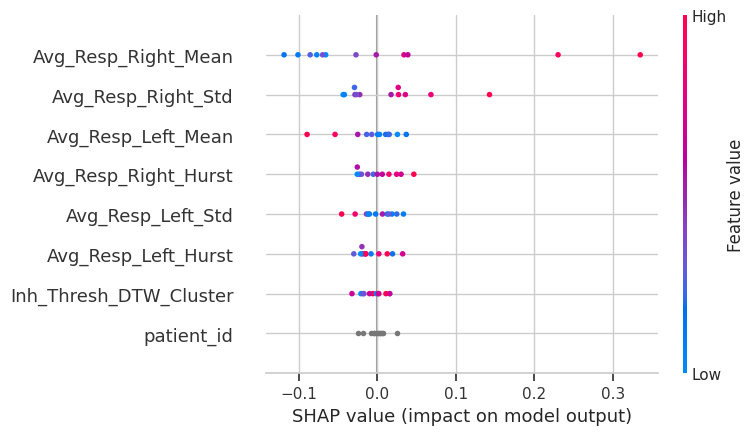

In [35]:
shap.summary_plot(shap_values[0], test_data[list(explainer.used_feats)])

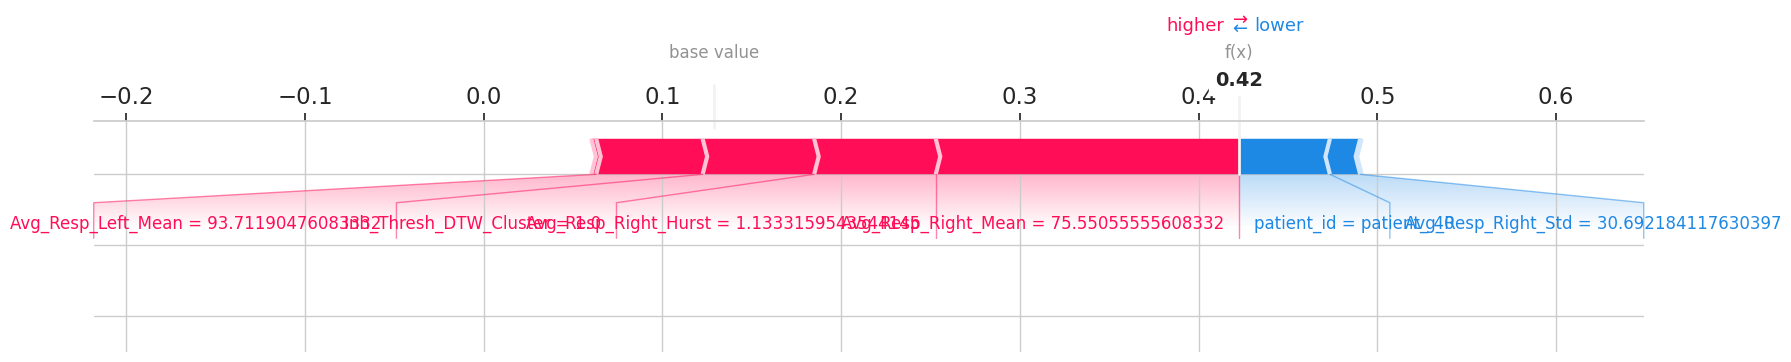

In [31]:

# individual force plot
shap.force_plot(explainer.expected_value[0], shap_values[1][0],
                test_data[explainer.used_feats].iloc[0], matplotlib=True)

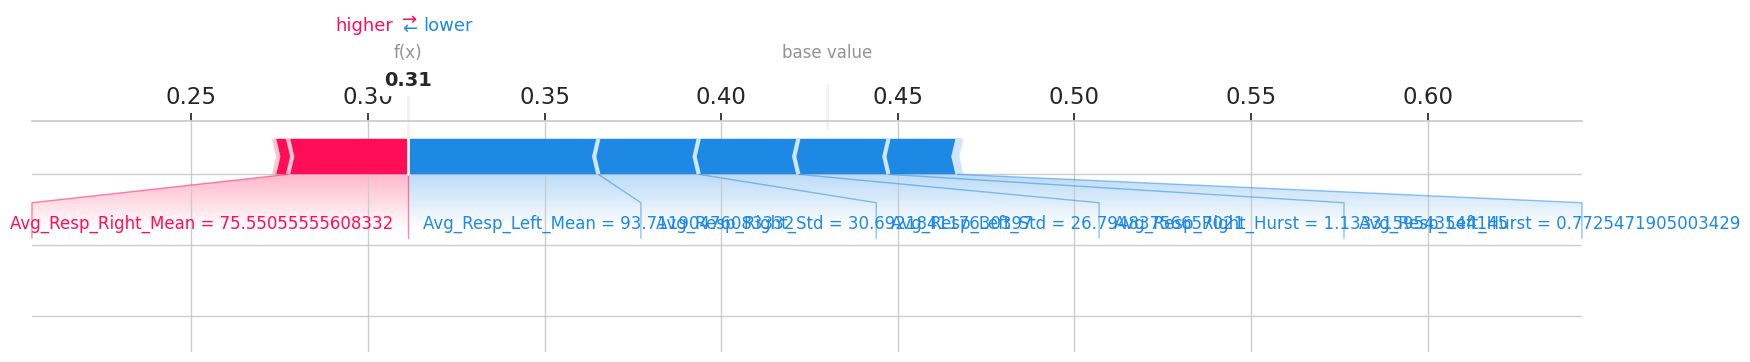

In [32]:
# individual force plot
shap.force_plot(explainer.expected_value[1], shap_values[0][1],
                test_data[explainer.used_feats].iloc[0], matplotlib=True)

In [33]:

X_test = test_data
X_test.reset_index(drop=['index'], inplace=True)
X_test = X_test.drop(columns=TARGET_NAME)
X_test.reset_index(drop=['index'], inplace=True)

In [34]:
shap.initjs()
shap.force_plot(explainer.expected_value[0],
                shap_values[0], X_test)